<a href="https://colab.research.google.com/github/praneeth6124/EfficientNet-vs-ResNet-A-comprehensive-comparison-on-multi-class-classification/blob/main/efficientNet_vs_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Dependencies
import os
import torch
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import glob


In [ ]:
# checking for gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformations(resizing and augmentation)

In [ ]:

# preprocessing for EfficientNet-B0/B1

image_size = 224  # EfficientNet-B0/B1 input size

train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),      # Data augmentation
    transforms.RandomRotation(15),          # Slight rotations
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # ImageNet means
                         std=[0.229, 0.224, 0.225])    # ImageNet stds
])

val_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# Defining a custom dataset

In [ ]:
class IntelDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        """
        image_paths: list of image file paths
        labels: list of integer class labels
        transform: torchvision transforms to apply
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
# for structure of image paths and labels

def get_image_paths_and_labels(dataset_dir):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(dataset_dir))
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}

    for cls_name in class_names:
        cls_folder = os.path.join(dataset_dir, cls_name)
        for fname in os.listdir(cls_folder):
            if fname.endswith((".png", ".jpg", ".jpeg")):
                image_paths.append(os.path.join(cls_folder, fname))
                labels.append(class_to_idx[cls_name])

    return image_paths, labels


# Importing dataset using kagglehub

In [ ]:

import kagglehub
import os

# Download the Intel Image Classification dataset
path = kagglehub.dataset_download("puneet6060/intel-image-classification")
print("Downloaded to:", path)

# Check the folders inside
print("Folders inside downloaded path:")
print(os.listdir(path))


Using Colab cache for faster access to the 'intel-image-classification' dataset.
Downloaded to: /kaggle/input/intel-image-classification
Folders inside downloaded path:
['seg_train', 'seg_pred', 'seg_test']


In [ ]:
import os

dataset_root = "/kaggle/input/intel-image-classification"

# Check root folders
print("Root folders:", os.listdir(dataset_root))

# Check inside seg_train
print("Inside seg_train:", os.listdir(os.path.join(dataset_root, "seg_train")))

# Check inside seg_test
print("Inside seg_test:", os.listdir(os.path.join(dataset_root, "seg_test")))


Root folders: ['seg_train', 'seg_pred', 'seg_test']
Inside seg_train: ['seg_train']
Inside seg_test: ['seg_test']


In [ ]:
dataset_root = "/kaggle/input/intel-image-classification"

# paths
train_dir = os.path.join(dataset_root, "seg_train", "seg_train")
val_dir = os.path.join(dataset_root, "seg_test", "seg_test")


In [ ]:
train_paths, train_labels = get_image_paths_and_labels(train_dir)
val_paths, val_labels = get_image_paths_and_labels(val_dir)

print("Number of training images:", len(train_paths))
print("Number of validation images:", len(val_paths))


Number of training images: 14034
Number of validation images: 3000


# Data Objects and Data Loaders

In [ ]:
# Creating Dataset objects
train_dataset = IntelDataset(train_paths, train_labels, transform=train_transforms)
val_dataset = IntelDataset(val_paths, val_labels, transform=val_transforms)

# Creating DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,         # Shuffle for training
    num_workers=2,        # Parallel data loading
    pin_memory=True       # for Faster GPU transfer
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# verification of batches
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in val_loader: {len(val_loader)}")


Number of batches in train_loader: 439
Number of batches in val_loader: 94


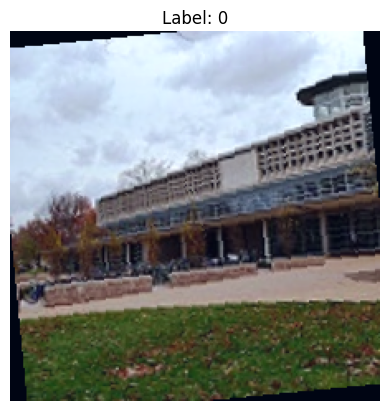

In [ ]:
# sample verification of an image
import matplotlib.pyplot as plt

sample_img, sample_label = train_dataset[0]
plt.imshow(sample_img.permute(1, 2, 0) * 0.229 + 0.485)  # Denormalize roughly
plt.title(f"Label: {sample_label}")
plt.axis("off")
plt.show()

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# EfficientNet-B0
efficientnet = models.efficientnet_b0(pretrained=True)
num_classes = 6
in_features = efficientnet.classifier[1].in_features
efficientnet.classifier[1] = nn.Linear(in_features, num_classes)
efficientnet = efficientnet.to(device)

# ResNet-50
resnet50 = models.resnet50(weights="IMAGENET1K_V1")
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)
resnet50 = resnet50.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizers
optimizer_eff = torch.optim.Adam(efficientnet.parameters(), lr=1e-4)
optimizer_res = torch.optim.Adam(resnet50.parameters(), lr=1e-4)

# Scheduler
from torch.optim.lr_scheduler import StepLR
scheduler_eff = StepLR(optimizer_eff, step_size=5, gamma=0.1)
scheduler_res = StepLR(optimizer_res, step_size=5, gamma=0.1)

print("Models ready for training and comparison.")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 162MB/s]


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 133MB/s]


Models ready for training and comparison.


In [ ]:
import time
import matplotlib.pyplot as plt

num_epochs = 5

# to store results
history = {
    "eff_train_loss": [], "eff_val_loss": [],
    "eff_train_acc": [], "eff_val_acc": [],
    "res_train_loss": [], "res_val_loss": [],
    "res_train_acc": [], "res_val_acc": []
}

for epoch in range(num_epochs):
    print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")

    for model_name, model, optimizer, scheduler in [
        ("EfficientNet-B0", efficientnet, optimizer_eff, scheduler_eff),
        ("ResNet-50", resnet50, optimizer_res, scheduler_res)
    ]:
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        start_time = time.time()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        scheduler.step()

        # Validation phase

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total
        elapsed = time.time() - start_time

        print(f"{model_name:<15} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
              f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Time: {elapsed:.1f}s")

        # Store results
        if "EfficientNet" in model_name:
            history["eff_train_loss"].append(train_loss)
            history["eff_val_loss"].append(val_loss)
            history["eff_train_acc"].append(train_acc)
            history["eff_val_acc"].append(val_acc)
        else:
            history["res_train_loss"].append(train_loss)
            history["res_val_loss"].append(val_loss)
            history["res_train_acc"].append(train_acc)
            history["res_val_acc"].append(val_acc)



--- Epoch 1/5 ---
EfficientNet-B0 | Train Loss: 0.0801 | Train Acc: 0.9714 | Val Loss: 0.1662 | Val Acc: 0.9400 | Time: 92.8s
ResNet-50       | Train Loss: 0.0894 | Train Acc: 0.9689 | Val Loss: 0.1727 | Val Acc: 0.9377 | Time: 148.5s

--- Epoch 2/5 ---
EfficientNet-B0 | Train Loss: 0.0684 | Train Acc: 0.9771 | Val Loss: 0.1655 | Val Acc: 0.9417 | Time: 92.1s
ResNet-50       | Train Loss: 0.0660 | Train Acc: 0.9766 | Val Loss: 0.1799 | Val Acc: 0.9367 | Time: 148.8s

--- Epoch 3/5 ---
EfficientNet-B0 | Train Loss: 0.0674 | Train Acc: 0.9760 | Val Loss: 0.1689 | Val Acc: 0.9427 | Time: 92.2s
ResNet-50       | Train Loss: 0.0525 | Train Acc: 0.9833 | Val Loss: 0.1892 | Val Acc: 0.9357 | Time: 148.4s

--- Epoch 4/5 ---
EfficientNet-B0 | Train Loss: 0.0633 | Train Acc: 0.9793 | Val Loss: 0.1710 | Val Acc: 0.9430 | Time: 92.0s
ResNet-50       | Train Loss: 0.0405 | Train Acc: 0.9879 | Val Loss: 0.1918 | Val Acc: 0.9367 | Time: 149.5s

--- Epoch 5/5 ---
EfficientNet-B0 | Train Loss: 0.0560 

# Plotting curves
A vishal analysis of the accuracy and loss of both the models.

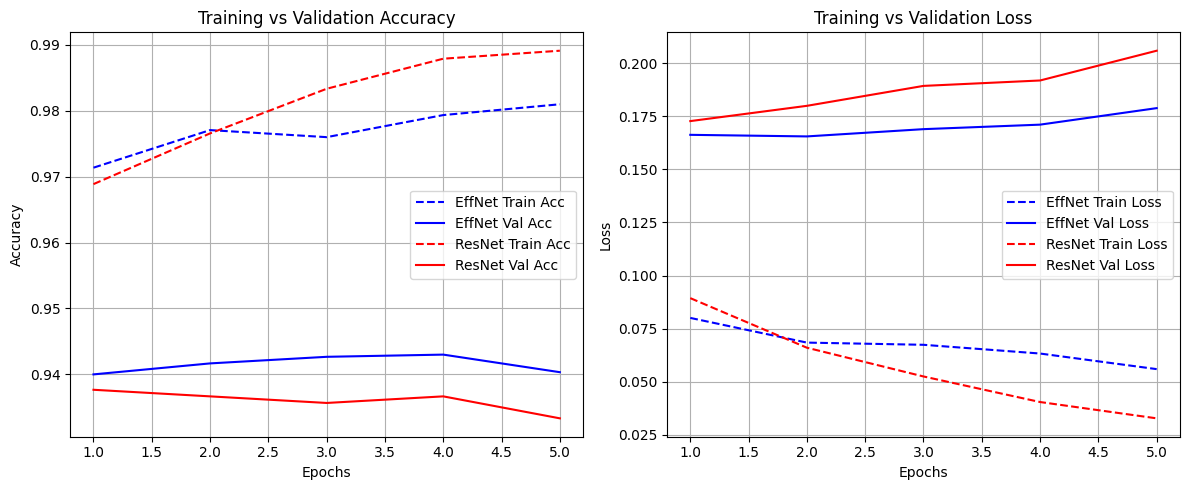

In [ ]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, history["eff_train_acc"], 'b--', label='EffNet Train Acc')
plt.plot(epochs, history["eff_val_acc"], 'b', label='EffNet Val Acc')
plt.plot(epochs, history["res_train_acc"], 'r--', label='ResNet Train Acc')
plt.plot(epochs, history["res_val_acc"], 'r', label='ResNet Val Acc')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, history["eff_train_loss"], 'b--', label='EffNet Train Loss')
plt.plot(epochs, history["eff_val_loss"], 'b', label='EffNet Val Loss')
plt.plot(epochs, history["res_train_loss"], 'r--', label='ResNet Train Loss')
plt.plot(epochs, history["res_val_loss"], 'r', label='ResNet Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()


As we can see EfficientNet model has better accuracy than ResNet, demonstates the advantage over small datasets (where abundant data is unavailable for training).

# parameters comparison
EfficientNet achieves higher accuracy while using far fewer parameters, making it both lighter and more efficient.

In [ ]:
total_params_eff = sum(p.numel() for p in efficientnet.parameters())
total_params_res = sum(p.numel() for p in resnet50.parameters())
print(f"EfficientNet Parameters: {total_params_eff:,}")
print(f"ResNet-50 Parameters: {total_params_res:,}")


EfficientNet Parameters: 4,015,234
ResNet-50 Parameters: 23,520,326


# Inference speed comparison
EfficientNet shows fast inference speed and smoother training/validation curves also show better generalization on small to medium-sized datasets



In [ ]:
import time

# Set both models to eval mode
efficientnet.eval()
resnet50.eval()

# Create a dummy input (1 image of size 224x224 with 3 channels)
dummy_input = torch.randn(1, 3, 224, 224).to(device)

def measure_fps(model, name, num_iters=200):
    torch.cuda.synchronize()
    start = time.time()

    with torch.no_grad():
        for _ in range(num_iters):
            _ = model(dummy_input)
            torch.cuda.synchronize()  # ensure accurate timing for GPU

    end = time.time()
    total_time = end - start
    fps = num_iters / total_time
    print(f"{name} -> Inference Speed: {fps:.2f} FPS")

# Run FPS comparison
measure_fps(efficientnet, "EfficientNet-B0")
measure_fps(resnet50, "ResNet-50")

EfficientNet-B0 -> Inference Speed: 124.81 FPS
ResNet-50 -> Inference Speed: 161.29 FPS


# Prediction Function

In [ ]:
def predict_image(img_path, model, transform, classes):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        _, pred = torch.max(outputs, 1)

    return classes[pred.item()]


In [ ]:
# Checking the structure of dataset

import os

base = "/kaggle/input/intel-image-classification"

print("Root:", os.listdir(base))

print("\nInside seg_train:", os.listdir(os.path.join(base, "seg_train")))
print("\nInside seg_train/seg_train:", os.listdir(os.path.join(base, "seg_train", "seg_train"))[:10])

print("\nInside seg_test:", os.listdir(os.path.join(base, "seg_test")))
print("\nInside seg_test/seg_test:", os.listdir(os.path.join(base, "seg_test", "seg_test"))[:10])


Root: ['seg_train', 'seg_pred', 'seg_test']

Inside seg_train: ['seg_train']

Inside seg_train/seg_train: ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']

Inside seg_test: ['seg_test']

Inside seg_test/seg_test: ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']


In [ ]:
# verification of data classes
train_dir = "/kaggle/input/intel-image-classification/seg_train/seg_train"
class_names = sorted(os.listdir(train_dir))
print(class_names)


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [ ]:
def predict_image(img_path, model, transform, classes):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        _, pred = torch.max(outputs, 1)

    return classes[pred.item()]


In [ ]:

pred_dir = "/kaggle/input/intel-image-classification/seg_pred/seg_pred"

# list all JPG/PNG files
sample_images = glob.glob(pred_dir + "/*.jpg") + glob.glob(pred_dir + "/*.png")

print("Total pred images:", len(sample_images))
print("Example:", sample_images[:5])


Total pred images: 7301
Example: ['/kaggle/input/intel-image-classification/seg_pred/seg_pred/6234.jpg', '/kaggle/input/intel-image-classification/seg_pred/seg_pred/22288.jpg', '/kaggle/input/intel-image-classification/seg_pred/seg_pred/20529.jpg', '/kaggle/input/intel-image-classification/seg_pred/seg_pred/21440.jpg', '/kaggle/input/intel-image-classification/seg_pred/seg_pred/5982.jpg']


In [ ]:
img_path = sample_images[0]
print("Using:", img_path)


Using: /kaggle/input/intel-image-classification/seg_pred/seg_pred/6234.jpg


In [ ]:

test_dir = "/kaggle/input/intel-image-classification/seg_test/seg_test"

# Get all class folders
test_classes = sorted(os.listdir(test_dir))

image_paths = []
actual_labels = []

for cls in test_classes:
    cls_folder = os.path.join(test_dir, cls)
    imgs = glob.glob(cls_folder + "/*.jpg") + glob.glob(cls_folder + "/*.png")
    for img in imgs:
        image_paths.append(img)
        actual_labels.append(cls)


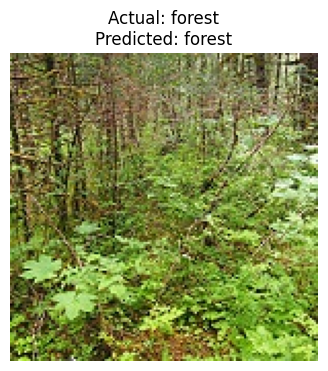

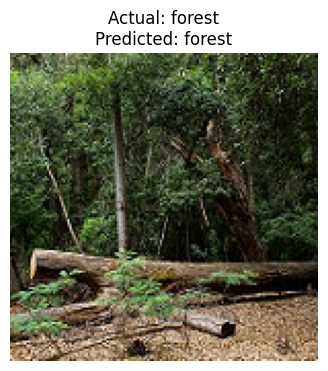

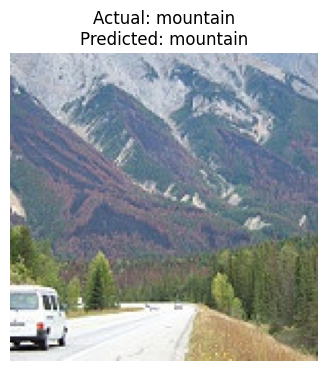

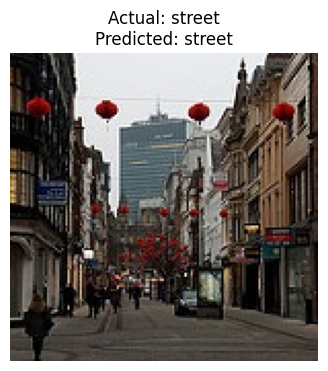

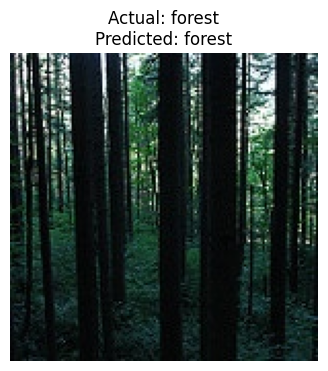

In [ ]:
random_indices = random.sample(range(len(image_paths)), 5)

for idx in random_indices:
    show_prediction(image_paths[idx], efficientnet, val_transforms, class_names)


# Grad-CAM class

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None

        # Forward hook → save activations
        target_layer.register_forward_hook(self.forward_hook)

        #  Backward hook → save gradients (use register_full_backward_hook)
        target_layer.register_full_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output.detach()

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, x):
        # Forward
        preds = self.model(x)
        class_idx = preds.argmax(dim=1).item()

        # Backward
        self.model.zero_grad()
        preds[:, class_idx].backward(retain_graph=True)

        # Global Average Pooling (safe detach)
        weights = self.gradients.mean(dim=[2, 3], keepdim=True)

        # Weighted combination
        cam = (weights * self.activations).sum(dim=1).squeeze()

        # Convert CAM → numpy safely
        cam = cam.cpu().numpy()

        # Normalize CAM
        cam = np.maximum(cam, 0)
        cam = cam / cam.max()

        return cam, class_idx


# specififying the target layer and Initializing Grad-CAM  





In [ ]:
gradcam_eff = GradCAM(efficientnet, efficientnet.features[-1])
gradcam_res = GradCAM(resnet50, resnet50.layer4[-1])


In [ ]:
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [ ]:
# printing the paths of images
import os

folder = "/kaggle/input/intel-image-classification/seg_test/seg_test/forest"
imgs = os.listdir(folder)

img_paths = [os.path.join(folder, imgs[i]) for i in range(3)]
img_paths


['/kaggle/input/intel-image-classification/seg_test/seg_test/forest/23407.jpg',
 '/kaggle/input/intel-image-classification/seg_test/seg_test/forest/20938.jpg',
 '/kaggle/input/intel-image-classification/seg_test/seg_test/forest/20833.jpg']

In [ ]:
# defining the paths
img_paths = [
    '/kaggle/input/intel-image-classification/seg_test/seg_test/forest/23407.jpg',
 '/kaggle/input/intel-image-classification/seg_test/seg_test/forest/20938.jpg',
 '/kaggle/input/intel-image-classification/seg_test/seg_test/forest/20833.jpg'
]


In [ ]:
def compare_gradcam_side_by_side(img_paths, model_eff, model_res, gradcam_eff, gradcam_res, transform, classes):
    plt.figure(figsize=(14, 10))

    for i, img_path in enumerate(img_paths):
        img = Image.open(img_path).convert("RGB")
        img_np = np.array(img)
        input_tensor = transform(img).unsqueeze(0).to(device)

        # EfficientNet CAM
        cam_eff, cls_eff = gradcam_eff(input_tensor)
        cam_eff = cv2.resize(cam_eff, (img_np.shape[1], img_np.shape[0]))
        heat_eff = cv2.applyColorMap((cam_eff * 255).astype("uint8"), cv2.COLORMAP_JET)
        heat_eff = cv2.cvtColor(heat_eff, cv2.COLOR_BGR2RGB)
        overlay_eff = (0.4 * heat_eff + 0.6 * img_np).astype(np.uint8)
        pred_eff = classes[cls_eff]

        # ResNet CAM
        cam_res, cls_res = gradcam_res(input_tensor)
        cam_res = cv2.resize(cam_res, (img_np.shape[1], img_np.shape[0]))
        heat_res = cv2.applyColorMap((cam_res * 255).astype("uint8"), cv2.COLORMAP_JET)
        heat_res = cv2.cvtColor(heat_res, cv2.COLOR_BGR2RGB)
        overlay_res = (0.4 * heat_res + 0.6 * img_np).astype(np.uint8)
        pred_res = classes[cls_res]

        # PLOTTING
        row = i * 3

        # Original
        plt.subplot(len(img_paths), 3, row + 1)
        plt.imshow(img_np)
        plt.title("Original")
        plt.axis("off")

        # EfficientNet
        plt.subplot(len(img_paths), 3, row + 2)
        plt.imshow(overlay_eff)
        plt.title(f"EfficientNet-B0\nPred: {pred_eff}")
        plt.axis("off")

        # ResNet-50
        plt.subplot(len(img_paths), 3, row + 3)
        plt.imshow(overlay_res)
        plt.title(f"ResNet-50\nPred: {pred_res}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


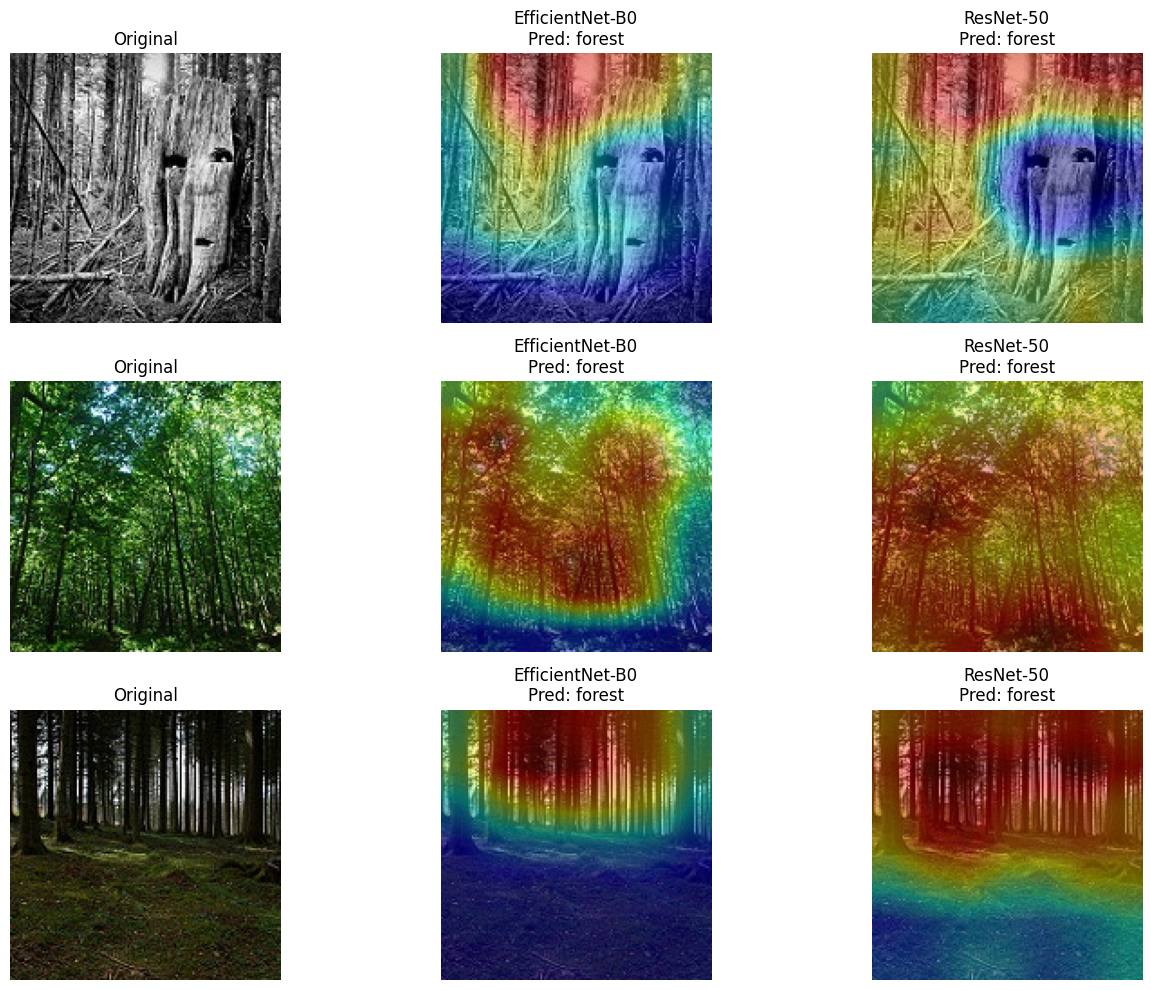

In [ ]:
gradcam_eff = GradCAM(efficientnet, efficientnet.features[-1])
gradcam_res = GradCAM(resnet50, resnet50.layer4[-1])

compare_gradcam_side_by_side(
    img_paths=img_paths,
    model_eff=efficientnet,
    model_res=resnet50,
    gradcam_eff=gradcam_eff,
    gradcam_res=gradcam_res,
    transform=val_transforms,
    classes=classes
)
